## Multimodal RAG Pipeline

### Imports

In [1]:
import torch
import os

from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader, DirectoryLoader

# pdf loader

from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
import pymupdf

# chunk splitter

from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import uuid
import chromadb
from chromadb.config import Settings
import shutil

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from tqdm import tqdm

# for invoking llms

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

# llava & qwen

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig, LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import Qwen3VLForConditionalGeneration
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import accelerate
from transformers.utils.import_utils import is_accelerate_available
import requests

# plotting

import matplotlib.pyplot as plt


# evaluation
import json
import re
from pathlib import Path

import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




#### use torch metrics explore these


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print("python:", __import__("sys").executable)
print("is_accelerate_available:", is_accelerate_available())


2.7.1+cu118
True
4
0
python: /opt/conda/envs/my_env/bin/python
is_accelerate_available: True


In [3]:
######### General Configurations #########
documents_path = "../siemens_test/" # relative path of all doc directories
vectordb_path = documents_path + "vectorDB/"
chunking_size = 1000  # Size of each chunk
chunking_step = 200 # Step size btw chunks

embedding_model_name = 'all-MiniLM-L6-v2'  # SentenceTransformer model name
image_embedding_model_name = "openai/clip-vit-large-patch14"  # CLIP model name

eval_dataset_path = "../eval/dataset.json"  # path to evaluation dataset


In [4]:
class PdfImagesLoader:
    """
    Extracts images from a PDF and returns one LangChain Document per image.
    Optionally saves each page as image and crops pages into a grid.

    Returns from .load():
        image_docs: list[Document]      # embedded images
        page_docs:  list[Document]      # full-page images + cropped page tiles
    """
    def __init__(
        self,
        pdf_path: str,
        images_root_dir: str,
        min_dim: int = 50,            # skip tiny images
        min_bytes: int = 0,           # skip small files
        min_bytes_per_px: float = 0,  # filter very compressed images if > 0
        extract_page_text: bool = True,
        store_to_folder: bool = True,
        pages_as_images: bool = False,
        pages_root_dir: str | None = None,
        page_zoom: float = 2.0,       # 1.0 ≈ 72dpi, 2.0 ≈ ~144dpi
        crop_pages: tuple[int, int] | None = None,  # (num_cols, num_rows)
    ):
        self.pdf_path = pdf_path
        self.images_root_dir = images_root_dir
        self.min_dim = min_dim
        self.min_bytes = min_bytes
        self.min_bytes_per_px = min_bytes_per_px
        self.extract_page_text = extract_page_text
        self.store_to_folder = store_to_folder

        self.pages_as_images = pages_as_images
        self.pages_root_dir = pages_root_dir
        self.page_zoom = page_zoom

        # crop_pages = (x_cols, y_rows); if None or (1,1) => no cropping
        self.crop_pages = crop_pages

    # this function is not my own, taken from pymupdf docs
    @staticmethod
    def _recover_pix(doc, xref, smask):
        if smask and smask > 0:
            base = pymupdf.Pixmap(doc.extract_image(xref)["image"])
            if base.alpha:
                base = pymupdf.Pixmap(base, 0)
            mask = pymupdf.Pixmap(doc.extract_image(smask)["image"])
            try:
                pix = pymupdf.Pixmap(base, mask)
            except Exception:
                pix = pymupdf.Pixmap(doc.extract_image(xref)["image"])
            ext = "pam" if (getattr(base, "n", 3) > 3) else "png"
            return {
                "ext": ext,
                "colorspace": pix.colorspace.n if pix.colorspace else 3,
                "image": pix.tobytes(ext),
            }

        if "/ColorSpace" in doc.xref_object(xref, compressed=True):
            pix = pymupdf.Pixmap(doc, xref)
            pix = pymupdf.Pixmap(pymupdf.csRGB, pix)
            return {"ext": "png", "colorspace": 3, "image": pix.tobytes("png")}

        return doc.extract_image(xref)

    def _render_page(self, page, out_dir_pages, pdf_stem, pdf_name, page_text):
        """Render a single full page to PNG and return a Document."""
        page_num = page.number + 1

        mat = pymupdf.Matrix(self.page_zoom, self.page_zoom)
        pix = page.get_pixmap(matrix=mat)  # RGB
        width, height = pix.width, pix.height
        filename = f"{pdf_stem}_p{page_num}_w{width}_h{height}.png"
        save_path = os.path.join(out_dir_pages, filename)

        if self.store_to_folder:
            os.makedirs(out_dir_pages, exist_ok=True)
            pix.save(save_path)

        return Document(
            page_content="",
            metadata={
                "type": "page_image",
                "doc_id": pdf_name,
                # add path of original pdf
                "file_path": self.pdf_path,
                "page": page_num,
                "page_image_path": save_path,
                "image_ext": "png",
                "width": width,
                "height": height,
                "has_image": True,
                "page_text": page_text,
                "url": f"{pdf_name}#page={page_num}",
            },
        )

    def _render_page_crops(self, page, out_dir_pages, pdf_stem, pdf_name, page_text):
        """
        Divide the page into a (cols x rows) grid and render each tile as an image.
        Returns a list of Documents with type == "page_crop".
        """
        if not self.crop_pages or self.crop_pages == (1, 1):
            return []

        num_cols, num_rows = self.crop_pages
        if num_cols <= 0 or num_rows <= 0:
            return []

        page_num = page.number + 1
        mat = pymupdf.Matrix(self.page_zoom, self.page_zoom)

        # Page coordinates (points)
        rect = page.rect
        page_w = rect.width
        page_h = rect.height

        cell_w = page_w / num_cols
        cell_h = page_h / num_rows

        crop_docs = []
        os.makedirs(out_dir_pages, exist_ok=True)

        for row in range(num_rows):
            for col in range(num_cols):
                # Define crop rectangle in page coordinates
                x0 = rect.x0 + col * cell_w
                y0 = rect.y0 + row * cell_h
                x1 = x0 + cell_w
                y1 = y0 + cell_h
                crop_rect = pymupdf.Rect(x0, y0, x1, y1)

                # Render only this region
                pix = page.get_pixmap(matrix=mat, clip=crop_rect)
                width, height = pix.width, pix.height

                filename = (
                    f"{pdf_stem}_p{page_num}_r{row}_c{col}_"
                    f"w{width}_h{height}.png"
                )
                save_path = os.path.join(out_dir_pages, filename)

                if self.store_to_folder:
                    pix.save(save_path)

                crop_docs.append(
                    Document(
                        page_content="",
                        metadata={
                            "type": "page_crop",
                            "doc_id": pdf_name,
                            "page": page_num,
                            "file_path": self.pdf_path,
                            "page_image_path": save_path,
                            "image_ext": "png",
                            "width": width,
                            "height": height,
                            "has_image": True,
                            "page_text": page_text,
                            "crop_row": row,
                            "crop_col": col,
                            "grid_cols": num_cols,
                            "grid_rows": num_rows,
                            "bbox_page_coords": str((float(x0), float(y0), float(x1), float(y1))),
                            "url": f"{pdf_name}#page={page_num}",
                        },
                    )
                )

        return crop_docs

    def load(self):
        image_docs = []
        page_docs = []

        pdf_name = os.path.basename(self.pdf_path)
        pdf_stem = os.path.splitext(pdf_name)[0]

        out_dir_imgs = os.path.join(self.images_root_dir, pdf_stem)
        if self.store_to_folder and not os.path.exists(out_dir_imgs):
            os.makedirs(out_dir_imgs, exist_ok=True)

        out_dir_pages = None
        if self.pages_as_images or (self.crop_pages and self.crop_pages != (1, 1)):
            # We need a pages_dir when we either save full pages or crops
            if not self.pages_root_dir:
                raise ValueError(
                    "pages_root_dir must be provided when pages_as_images=True "
                    "or crop_pages is set."
                )
            out_dir_pages = os.path.join(self.pages_root_dir, pdf_stem)
            if self.store_to_folder and not os.path.exists(out_dir_pages):
                os.makedirs(out_dir_pages, exist_ok=True)

        with pymupdf.open(self.pdf_path) as doc:
            for page in doc:
                page_num = page.number + 1
                page_text = page.get_text() if self.extract_page_text else ""

                # --- Full page image ---
                if self.pages_as_images:
                    page_docs.append(
                        self._render_page(
                            page=page,
                            out_dir_pages=out_dir_pages,
                            pdf_stem=pdf_stem,
                            pdf_name=pdf_name,
                            page_text=page_text,
                        )
                    )

                # --- Page crops ---
                if self.crop_pages and self.crop_pages != (1, 1):
                    crop_docs = self._render_page_crops(
                        page=page,
                        out_dir_pages=out_dir_pages,
                        pdf_stem=pdf_stem,
                        pdf_name=pdf_name,
                        page_text=page_text,
                    )
                    page_docs.extend(crop_docs)

                # --- Embedded images (xref) ---
                for info in page.get_image_info(xrefs=True, hashes=False):
                    xref = info.get("xref")
                    smask = info.get("smask")
                    bbox = info.get("bbox")
                    width = int(info.get("width", 0))
                    height = int(info.get("height", 0))

                    if xref is None or min(width, height) < self.min_dim:
                        continue

                    try:
                        data = self._recover_pix(doc, xref, smask)
                        ext = data.get("ext", "png")
                        img_bytes = data["image"]
                        colorspace = data.get("colorspace", 3)

                        if len(img_bytes) < self.min_bytes:
                            continue
                        if self.min_bytes_per_px > 0:
                            if (len(img_bytes) / max(1, (width * height * colorspace))) < self.min_bytes_per_px:
                                continue

                        filename = (
                            f"{pdf_stem}_p{page_num}_x{xref}_w{width}_h{height}.{ext}"
                        )
                        save_path = os.path.join(out_dir_imgs, filename)

                        if self.store_to_folder:
                            with open(save_path, "wb") as f:
                                f.write(img_bytes)

                        image_docs.append(
                            Document(
                                page_content="",
                                metadata={
                                    "type": "image",
                                    "doc_id": pdf_name,
                                    "page": page_num,
                                    "file_path": self.pdf_path,
                                    "image_path": save_path,
                                    "image_ext": ext,
                                    "image_xref": xref,
                                    "width": width,
                                    "height": height,
                                    "bbox": str(bbox),
                                    "has_image": True,
                                    "page_text": page_text,
                                    "url": f"{pdf_name}#page={page_num}",
                                },
                            )
                        )
                    except Exception as ex:
                        # Bad xref / decoding issue: warn and continue.
                        # This ensures pages and crops are still processed.
                        print(
                            f"[WARN] Skipping embedded image xref={xref} on "
                            f"{pdf_name} page {page_num} due to error: {ex}"
                        )
                        continue

        return image_docs, page_docs

    # this is adopted from langchain's DirectoryLoader pattern
    @classmethod
    def load_from_directory(
        cls,
        pdfs_dir,
        images_dir,
        pages_dir=None,
        pages_as_images=False,
        crop_pages: tuple[int, int] | None = None,
        **kwargs,
    ):
        """
        Walk `pdfs_dir` and collect:
        - image Documents to `images_dir`
        - page-image + crop Documents to `pages_dir`
          (if pages_as_images=True or crop_pages is not None)

        Returns (all_image_docs, all_page_docs).
        """
        all_image_docs, all_page_docs = [], []
        pdf_files = [
            os.path.join(pdfs_dir, f)
            for f in os.listdir(pdfs_dir)
            if f.lower().endswith(".pdf")
        ]
        for pdf_path in tqdm(pdf_files, desc="Extracting images/pages from PDFs"):
            loader = cls(
                pdf_path=pdf_path,
                images_root_dir=images_dir,
                pages_as_images=pages_as_images,
                pages_root_dir=pages_dir,
                crop_pages=crop_pages,
                **kwargs,
            )
            try:
                img_docs, page_docs = loader.load()
                all_image_docs.extend(img_docs)
                all_page_docs.extend(page_docs)
            except Exception as ex:
                # Now, only truly fatal errors will skip a whole file. 
                # Individual bad xrefs are handled inside .load().
                print(f"[WARN] Skipping {os.path.basename(pdf_path)} due to error: {ex}")
        return all_image_docs, all_page_docs


### Importing Data


In [5]:
# text-only extraction
# add  "file_path": self.pdf_path to each document's metadata

dir_loader_pdf = DirectoryLoader(documents_path + "pdfs/",
                                    glob="*.pdf",
                                    loader_cls=PyMuPDFLoader,
                                    loader_kwargs={"extract_images": False},
                                    show_progress=True)
documents_pdf = dir_loader_pdf.load()

100%|██████████| 26/26 [00:02<00:00,  9.54it/s]


In [6]:
# image extraction (embedded images & pages as images)

os.makedirs(documents_path + "pdfs/extracted_images/", exist_ok=True)

documents_pdf_imgs, documents_pdf_pages = PdfImagesLoader.load_from_directory(pdfs_dir=documents_path + "pdfs/",
                    images_dir=documents_path + "pdfs/extracted_images/",
                    pages_dir=documents_path + "pdfs/extracted_pages/",
                    pages_as_images=True,
                    min_dim=50,
                    min_bytes=0,
                    min_bytes_per_px=0.0,
                    extract_page_text=True,
                    store_to_folder=True,
                    page_zoom=2.0,
                    crop_pages=(2,2)
                    )
pdf_image_paths = [doc.metadata["image_path"] for doc in documents_pdf_imgs]
pdf_pages_paths = [doc.metadata["page_image_path"] for doc in documents_pdf_pages]

print(f"Extracted {len(documents_pdf_imgs)} embedded-image documents.")
print(f"Rendered {len(documents_pdf_pages)} page-image documents.")
if documents_pdf_imgs:
    ex = documents_pdf_imgs[0]
print("Example embedded image doc:", {k: ex.metadata[k] for k in ["doc_id","page","image_path","width","height"]})
if documents_pdf_pages:
    exp = documents_pdf_pages[0]
print("Example page image doc:", {k: exp.metadata[k] for k in ["doc_id","page","page_image_path","width","height"]})

Extracting images/pages from PDFs:  27%|██▋       | 7/26 [00:29<00:51,  2.69s/it]

[WARN] Skipping embedded image xref=0 on user-manual-26104_(manymanuals.com).pdf page 8 due to error: bad xref


Extracting images/pages from PDFs:  38%|███▊      | 10/26 [00:41<00:57,  3.60s/it]

[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 1 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 2 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 2 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 2 due to error: bad xref
[WARN] Skipping embedded image xref=0 on colorimeter.pdf page 2 due to error: bad xref
[WARN] Skipping embedded image xref=0 on co

Extracting images/pages from PDFs:  85%|████████▍ | 22/26 [01:36<00:16,  4.12s/it]

[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: bad xref
[WARN] Skipping embedded image xref=0 on user-manual-14861_(manymanuals.com).pdf page 12 due to error: b

Extracting images/pages from PDFs:  88%|████████▊ | 23/26 [01:45<00:16,  5.46s/it]

[WARN] Skipping embedded image xref=0 on vacuum_circuitbreaker.pdf page 14 due to error: bad xref
[WARN] Skipping embedded image xref=0 on vacuum_circuitbreaker.pdf page 35 due to error: bad xref


Extracting images/pages from PDFs:  92%|█████████▏| 24/26 [01:50<00:11,  5.53s/it]

[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 67 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pdf page 120 due to error: bad xref
[WARN] Skipping embedded image xref=0 on specifications-5740_(manymanuals.com).pd

Extracting images/pages from PDFs: 100%|██████████| 26/26 [02:18<00:00,  5.35s/it]

Extracted 584 embedded-image documents.
Rendered 4210 page-image documents.
Example embedded image doc: {'doc_id': 'user-manual-39017_(manymanuals.com).pdf', 'page': 1, 'image_path': '../siemens_test/pdfs/extracted_images/user-manual-39017_(manymanuals.com)/user-manual-39017_(manymanuals.com)_p1_x483_w1003_h602.png', 'width': 1003, 'height': 602}
Example page image doc: {'doc_id': 'user-manual-39017_(manymanuals.com).pdf', 'page': 1, 'page_image_path': '../siemens_test/pdfs/extracted_pages/user-manual-39017_(manymanuals.com)/user-manual-39017_(manymanuals.com)_p1_w1190_h1684.png', 'width': 1190, 'height': 1684}


### Chunking Documents



In [7]:
def chunk_documents(documents, chunk_size=chunking_size, chunk_step=chunking_step):
    """Splits documents into chunks of 1000 characters with 200 characters step size."""
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_step,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(split_docs)} chunks")

    
    if split_docs:
        print(f"\nExample chunk:")
        print(f"Content: {split_docs[0].page_content[:200]}...")
        print(f"Metadata: {split_docs[0].metadata}")

    return split_docs
    

chunks_pdf = chunk_documents(documents_pdf)



Split 842 documents into 2034 chunks

Example chunk:
Content: User's Guide
MC35 Module
MC35 Terminal
Version:  02.00
DocID:  MC35 SAT 01 v02.00...
Metadata: {'producer': 'Acrobat Distiller 4.05 for Windows', 'creator': '', 'creationdate': 'D:20020111204453', 'source': '../siemens_test/pdfs/user-manual-39017_(manymanuals.com).pdf', 'file_path': '../siemens_test/pdfs/user-manual-39017_(manymanuals.com).pdf', 'total_pages': 65, 'format': 'PDF 1.3', 'title': 'Version History', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2002-01-15T11:07:31+01:00', 'trapped': '', 'modDate': "D:20020115110731+01'00'", 'creationDate': 'D:20020111204453', 'page': 0}


### Embedding Document Chunks

In [8]:
class EmbeddingManager:
    """
    This class handles the embeddings of the query and the docs, using the create_embeddings() function and model_name input from HuggingFace

    ```
    """
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        self._load_model()
        
    def _load_model(self):
        """
        Attempts to load the model with model_name from SentenceTransformers Library
        """
        try:
            self.model = SentenceTransformer(self.model_name).to("cuda:0")
            print(f"EMbedding model {self.model_name} is successfully loaded. n_dim = {self.model.get_sentence_embedding_dimension()}")
        except Exception as exc:
            print(f"Error loading embedding model: {self.model_name} {exc}")
            raise
    def create_embeddings(self, documents):
        """
        Creates embeddings for the documents using the loaded model.

        Returns:
            list: List of embeddings for the documents.
        """
        if not self.model:
            raise ValueError("Embedding model is not loaded.")
        
        if type(documents) is not str:
            texts = [doc.page_content for doc in documents]
        else:
            texts = [documents]
        embeddings = self.model.encode(texts, batch_size=32, device="cuda:0", show_progress_bar=True)
        return embeddings

In [9]:
class EmbeddingManager_Image:
    def __init__(self, model_name="openai/clip-vit-large-patch14"):
        self.model_name = model_name
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()

    def embed_images(self, image_paths, batch_size=16):
        """
        Embed a list of image paths with optional batching.
        """
        all_feats = []

        # simple batching 
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            images = [Image.open(p).convert("RGB") for p in batch_paths]

            inputs = self.processor(
                images=images,
                return_tensors="pt",
                padding=True,
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                img_feats = self.model.get_image_features(**inputs)

            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            all_feats.append(img_feats.cpu())

        all_feats = torch.cat(all_feats, dim=0)
        return all_feats.numpy()

    def embed_texts(self, texts, batch_size=32):
        """
        Embed a list of texts using CLIP text tower.
        """
        all_feats = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = self.processor(
                text=batch_texts,
                return_tensors="pt",
                padding=True,
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                txt_feats = self.model.get_text_features(**inputs)

            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            all_feats.append(txt_feats.cpu())

        all_feats = torch.cat(all_feats, dim=0)
        return all_feats.numpy()


In [10]:
embedding_manager_txt = EmbeddingManager(model_name=embedding_model_name)
embedding_manager_images = EmbeddingManager_Image(model_name=image_embedding_model_name)

EMbedding model all-MiniLM-L6-v2 is successfully loaded. n_dim = 384


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
# run this if you want to create embeddings from scratch

embeddings_pdf = embedding_manager_txt.create_embeddings(chunks_pdf)
embeddings_pdf_images = embedding_manager_images.embed_images(pdf_image_paths)
embeddings_pdf_pages = embedding_manager_images.embed_images(pdf_pages_paths)

print(len(embeddings_pdf), len(embeddings_pdf[0]))
print(len(embeddings_pdf_images), len(embeddings_pdf_images[0]))
print(len(embeddings_pdf_pages), len(embeddings_pdf_pages[0]))

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

2034 384
584 768
4210 768


### VectorDB

In [12]:
# wipe the whole vectorDB directory 

shutil.rmtree(vectordb_path, ignore_errors=True)
os.makedirs(vectordb_path, exist_ok=True)

In [13]:

class VectorDBManager:
    def __init__(self, collection_name = "unnamed", directory=vectordb_path, source_type = "undefined"):

        self.directory = directory
        self.collection_name = collection_name
        self.collection = None
        self.client = None
        self.source_type = source_type

        self._init_db()
        
    def _init_db(self):
        try:
            # create client
            os.makedirs(self.directory, exist_ok = True)
            self.client = chromadb.PersistentClient(path=self.directory)
            # create collection
            self.collection = self.client.get_or_create_collection(name = self.collection_name,
                                                                metadata = {"description" : f"Vector DB for RAG embeddings from {self.source_type}"}
                                                                )
            print(f"Vector DB initialized at {self.directory} with collection name '{self.collection_name}'")
            print(f"Currently stored vectors: {self.collection.count()}")
        except Exception as exc:
            print(f"Error initializing Vector DB: {exc}")
            raise
            
    def add_documents(self, documents, embeddings):
        """
        This function can be used to add new documents & their embeddings to the vectorDB

        Args:
            documents (list): ordered list of langchain documents
            embeddings (list): ordered list of embeddings from above documents
        """
        print(f"Adding {len(documents)} documents...")
        
        # check sizes just in case
        if len(documents) != len(embeddings):
            raise ValueError("The number of documents and embeddings must be the same.")
        
        id_list = []
        document_content_list = []
        embedding_list = []
        metadata_list = []
        
        
        for i, (doc, embed) in enumerate(zip(documents, embeddings)):
            
            #this is just to give each entry a unique id to avoid collisions in db
            id = f"doc_{uuid.uuid4().hex[:16]}_{i}"
            id_list.append(id)
            
            metadata = doc.metadata
            metadata["doc_index"] = i
            metadata["length"] = len(doc.page_content)
            metadata["source_type"] = self.source_type
            metadata_list.append(metadata)
            
            document_content_list.append(doc.page_content)
            embedding_list.append(embed.tolist())
            
        try:
            self.collection.add(
                ids = id_list,
                metadatas = metadata_list,
                documents = document_content_list,
                embeddings = embedding_list
                )
            print(f"Successfully added {len(id_list)} documents to Vector DB.")
            print(f"Currently stored vectors: {self.collection.count()}")
                
        except Exception as exc:
            print(f"Error adding document {id} to Vector DB: {exc}")
            raise
            


In [14]:
vector_db_manager_pdf = VectorDBManager(collection_name="pdf_documents_db",
                                        directory=os.path.join(vectordb_path, "pdf_db/"),
                                        source_type="pdf")
vector_db_manager_pdf_images = VectorDBManager(collection_name="pdf_image_documents_db",
                                        directory=os.path.join(vectordb_path, "pdf_image_db/"),
                                        source_type="pdf_image")

Vector DB initialized at ../siemens_test/vectorDB/pdf_db/ with collection name 'pdf_documents_db'
Currently stored vectors: 0
Vector DB initialized at ../siemens_test/vectorDB/pdf_image_db/ with collection name 'pdf_image_documents_db'
Currently stored vectors: 0


In [15]:
# run this if you want to add docs

vector_db_manager_pdf.add_documents(documents=chunks_pdf,
                                    embeddings=embeddings_pdf)
vector_db_manager_pdf_images.add_documents(documents=documents_pdf_pages,
                                    embeddings=embeddings_pdf_pages)

Adding 2034 documents...
Successfully added 2034 documents to Vector DB.
Currently stored vectors: 2034
Adding 4210 documents...
Successfully added 4210 documents to Vector DB.
Currently stored vectors: 4210


### Retriever

#### Image & text retrieval (idk what to do with page content data)


In [9]:
class RetrieverMultiModal:
    def __init__(self, vector_db_text, vector_db_image, embedding_manager_text, embedding_manager_image):
        self.vector_db_text = vector_db_text
        self.vector_db_image = vector_db_image
        self.embedding_manager_text = embedding_manager_text
        self.embedding_manager_image = embedding_manager_image


    def retrieve(self, query, top_k_text, top_k_image, match_threshold_text=-0.5, match_threshold_image=-0.5):

        print(f"Retrieving {top_k_text} text document chunks and {top_k_image} image document chunks...")

        try:
            query_embedding_text = self.embedding_manager_text.create_embeddings(query)[0].tolist()
            results_text = self.vector_db_text.collection.query(
                query_embeddings=[query_embedding_text],
                n_results=top_k_text
            )

            query_embedding_image = self.embedding_manager_image.embed_texts(query)[0].tolist()
            results_image = self.vector_db_image.collection.query(
                query_embeddings=[query_embedding_image],
                n_results=top_k_image
            )
        
            results_list_text = []

            if results_text["ids"][0]:
                for i in range(len(results_text["ids"][0])):
                    score = 1 - results_text["distances"][0][i]
                    if score >= match_threshold_text:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_text["ids"][0][i],
                            "document": results_text["documents"][0][i],
                            "metadata": results_text["metadatas"][0][i],
                            "modality": "text",
                            "score": score
                        }
                        results_list_text.append(result)
                print(f"Retrieved {len(results_list_text)} documents above the threshold of {match_threshold_text}.")
            else:
                print("No text documents retrieved.")
            
            results_list_image = []
            if results_image["ids"][0]:
                for i in range(len(results_image["ids"][0])):
                    score = 1 - results_image["distances"][0][i]
                    if score >= match_threshold_image:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_image["ids"][0][i],
                            "document": results_image["documents"][0][i],
                            "metadata": results_image["metadatas"][0][i],
                            "modality": "image",
                            "score": score
                        }
                        results_list_image.append(result)
                print(f"Retrieved {len(results_list_image)} image documents above the threshold of {match_threshold_image}.")
            else:
                print("No image documents retrieved.")

            return results_list_text, results_list_image

        except Exception as exc:
            print(f"Error retrieving: {exc}")
            raise
        
retriever_multimodal = RetrieverMultiModal(
    vector_db_text=vector_db_manager_pdf,
    vector_db_image=vector_db_manager_pdf_images,
    embedding_manager_text=embedding_manager_txt,
    embedding_manager_image=embedding_manager_images
)

Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text Doc 1 (Score: -0.45  page: 22):

Installation
2-7
Series 505 High Speed Counter 
and Encoder Module User’s Manual
2.3
Inserting the Module in the I/O Base
The HSC is a single-wide module. Insert it into any available slot on any
Series 505 I/O base. Do not touch the printed circuit board while inserting
the module. This could cause electrostatic damage to the components on
the board. Insert the module as shown in Figure 2-3.
!

To minimize potential shock, turn off power to the I/O base and any
modules installed in the...

Text Doc 2 (Score: -0.45  page: 35):
HSC Connections
As the sprayer moves up and down, the channel 1 outputs and the sprayer
enable signal levels produce the waveform shown in Figure 5-3.
OFF
ON
OFF
ON
OFF
LS1
P1
P2
LS2
P2
P1
LS1
Travels Up
Travels Down
Sprayer Travel
OUTPUT 1
OUTPUT 2
Sprayer Enable
Figure 5-3
Waveform Pattern...

Text Doc 3 (Scor

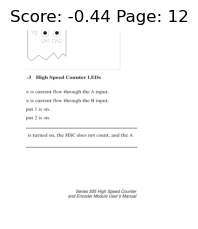

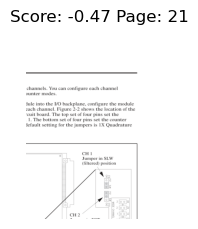

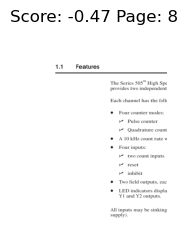

In [10]:
test = retriever_multimodal.retrieve(
        query="Explain how to connect the the SAMMS-MV device to the SEAbus.",
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.6
        )

# plot retrieved images

retrieved_texts = test[0]
for i, text_doc in enumerate(retrieved_texts):
    print(f"Text Doc {i+1} (Score: {text_doc['score']:.2f}  page: {text_doc['metadata'].get('page')}):")
    print(text_doc["document"][:500] + "...\n")

retrieved_images = test[1]
for i, img_doc in enumerate(retrieved_images):
    img_path = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, len(retrieved_images), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {img_doc['score']:.2f} Page: {img_doc['metadata'].get('page')}")
        plt.show()

#### Experimental Retriever

In [33]:
class RetrieverMultiModal_experimental:
    def __init__(self, vector_db_text, vector_db_image, embedding_manager_text, embedding_manager_image):
        self.vector_db_text = vector_db_text
        self.vector_db_image = vector_db_image
        self.embedding_manager_text = embedding_manager_text
        self.embedding_manager_image = embedding_manager_image


    def retrieve(self, query_text, query_image, top_k_text, top_k_image, match_threshold_text=-0.5, match_threshold_image=-0.5):

        print(f"Retrieving {top_k_text} text document chunks and {top_k_image} image document chunks...")

        try:
            query_embedding_text = self.embedding_manager_text.create_embeddings(query_text)[0].tolist()
            results_text = self.vector_db_text.collection.query(
                query_embeddings=[query_embedding_text],
                n_results=top_k_text
            )
            
            retrieved_doc_names_page_num = [{"doc_name": md["file_path"].split("\\")[-1], "page": md["page"]} for md in results_text["metadatas"][0] if "page" in md]

            query_embedding_image = self.embedding_manager_image.embed_texts(query_image)[0].tolist()
            results_image = self.vector_db_image.collection.query(
                query_embeddings=[query_embedding_image],
                #where={ "doc_id": {"$in": [doc["doc_name"] for doc in retrieved_doc_names_page_num]} },
                n_results=top_k_image
            )
        
            results_list_text = []

            if results_text["ids"][0]:
                for i in range(len(results_text["ids"][0])):
                    score = 1 - results_text["distances"][0][i]
                    if score >= match_threshold_text:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_text["ids"][0][i],
                            "document": results_text["documents"][0][i],
                            "metadata": results_text["metadatas"][0][i],
                            "modality": "text",
                            "score": score
                        }
                        results_list_text.append(result)
                print(f"Retrieved {len(results_list_text)} documents above the threshold of {match_threshold_text}.")
            else:
                print("No text documents retrieved.")
            
            results_list_image = []
            if results_image["ids"][0]:
                for i in range(len(results_image["ids"][0])):
                    score = 1 - results_image["distances"][0][i]
                    if score >= match_threshold_image:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_image["ids"][0][i],
                            "document": results_image["documents"][0][i],
                            "metadata": results_image["metadatas"][0][i],
                            "modality": "image",
                            "score": score
                        }
                        results_list_image.append(result)
                print(f"Retrieved {len(results_list_image)} image documents above the threshold of {match_threshold_image}.")
            else:
                print("No image documents retrieved.")

            return results_list_text, results_list_image

        except Exception as exc:
            print(f"Error retrieving: {exc}")
            raise
        
retriever_multimodal_exp = RetrieverMultiModal_experimental(
    vector_db_text=vector_db_manager_pdf,
    vector_db_image=vector_db_manager_pdf_images,
    embedding_manager_text=embedding_manager_txt,
    embedding_manager_image=embedding_manager_images
)

In [17]:
test = retriever_multimodal_exp.retrieve(
        query_text="Explain how to connect the the SAMMS-MV device to the SEAbus.",
        query_image="Show me an image of the SAMMS-MV device.",
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.6
        )

# plot retrieved images

retrieved_texts = test[0]
for i, text_doc in enumerate(retrieved_texts):
    print(f"Text Doc {i+1} (Score: {text_doc['score']:.2f}  page: {text_doc['metadata'].get('page')}):")
    print(text_doc["document"][:500] + "...\n")

retrieved_images = test[1]
for i, img_doc in enumerate(retrieved_images):
    img_path = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, len(retrieved_images), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {img_doc['score']:.2f} Page: {img_doc['metadata'].get('page')}")
        plt.show()

Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
No image documents retrieved.
Text Doc 1 (Score: 0.49  page: 11):
10
2 Installing the SAMMS-MV Device
enables the SAMMS-MV to communicate with a remote super-
visory device. Examples of the remote supervisory device
include the Power Monitor display and monitoring unit, a
standard personal computer running the Power Monitor PC
communications and supervisory software, or Siemens
Microsoft® Windows™ based SIEServe™ or WinPM™ soft-
ware. These supervisory devices and programs can communi-
cate with the SAMMS-MV device and allow it to operate in the
ACCESS electri...

Text Doc 2 (Score: 0.17  page: 11):
the ACCESS network.
Figure 2.3 SAMMS-MV device communications connections
1 2 3 4
1 = -
2 = GND
3 = +
4 = 12VDC+
5 = 12VDC-
Top View
Side View
Rear View
Proper make-up of 5 pin plug
12Vdc(-)
12Vdc(+)
Comm Cable
Comm Cable
BLK
WHT
Shield
Rear view of the SAMMS-MV device
Ribbon cable assembly
SAMMS
Communications
Module
CM-1
5 pin plug
12345


### Language Model Setup

In [18]:
""" Here I will set up multiple open source and/or proprietary LLMs for RAG
    
    I will use prompt templates to generate responses based on retrieved context.
    I will implement a simple RAG class and advanced RAG class, which take different llms as input.
    Each llm will have its own input prompt template.
    I will try to modularize the code as much as possible (i.e. same RAG class can take different llms as input).
    Models I plan to use:
    - Groq Qwen 3.2 32B
    - LlaVa 2 13B (or 7B)
    
    I will try to focus more on LLMs hosted on Groq and HF, also LLMs which use openai API, also LLMs using local inference (if time permits).
    
    In this cell I will set up LLMs and their prompt templates, and in the next cell I will set up RAG classes.
    
"""


groq_api_key = os.getenv("GROQ_API_KEY")


query = "testquery"
context = "testcontext"
def message_general(query, context):
    return [
        SystemMessage(content="You are a helpful assistant that provides concise answers."),
        HumanMessage(content=f"Use the following context to answer the question concisely.\n\nContext:\n{context}\n\nQuestion: {query}\n\nAnswer:"),
    ]
    
def message_expander(query, length):
    return [
        SystemMessage(content="You are a helpful assistant that expands user queries into detailed, specific queries for document retrieval."),
        HumanMessage(content=f"Expand the following query to approximately {length} characters, adding relevant details and context to improve retrieval accuracy.\n\nQuery: {query}\n\nExpanded Query:"),
    ]
    
def message_cot(query):
    return [
        SystemMessage(content="You are a helpful assistant that expands user questions into step-by-step reasoning paths, asking intermediate questions to improve document retrieval accuracy."),
        HumanMessage(content=f"Expand the following question into a step-by-step reasoning path, formulating intermediate questions to guide document retrieval.\n\nQuestion: {query}\n\nReasoning Path:"),
    ]
    
def message_summarizer(message):
    return [
        SystemMessage(content="You are a helpful assistant that summarizes long contexts into concise summaries."),
        HumanMessage(content=f"Summarize the following context concisely, focusing on key points and relevant information.\n\nContext:\n{message}\n\nSummary:"),
    ]
    
def message_image_caption_generator(message):
    return [
        SystemMessage(content="You are a helpful assistant that generates relevant image captions from questions for image retrieval."),
        HumanMessage(content=f"Given the question below, generate a retrieval-optimized caption for an image that would help answer this question in an industrial manual.\n\nThe caption must:\n- describe the type of image likely found in such a manual (e.g., schematic, wiring diagram, pinout, UI screenshot, parameter table, flowchart, graph)\n- include the key technical terms from the question (device names, model numbers, components)\n- avoid hallucinating numeric values or details not implied by the question\n- be specific, descriptive, and useful for image retrieval\n- be 1-2 sentences long.\n\nContext:\n{message}\n\nImage Caption:"),
    ]

# Setting up LLMs
llm_qwen = ChatGroq(groq_api_key=groq_api_key,model_name="qwen/qwen3-32b",temperature=0.1,max_tokens=1024)
llm_llama31 = ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant",temperature=0.1,max_tokens=1024)
llm_gpt_oss = ChatGroq(groq_api_key=groq_api_key,model_name="openai/gpt-oss-20b",temperature=0.1,max_tokens=1024)



### RAG Multimodal Pipeline Class (Advanced)

In [19]:
# helper functions to build inputs for different LLMs

def build_llava_inputs(
    processor_llava,
    query,
    text_context,
    image_paths,
    max_images = 1,
    device = "cuda:0"):
    
    """
    Build inputs for LLaVA
    Uses up to `max_images` from image_paths. The number of retrieved images (top_k) must be equal to this one.
    """
    # textual part
    text_content = (
        "You are a helpful assistant for industrial manuals.\n\n"
        "Use the following text context and image(s) to answer the question.\n\n"
        f"Text Context:\n{text_context}\n\n"
        f"Question: {query}\n\n"
        "Answer:"
    )

    # Open images 
    selected_paths = image_paths[:max_images]
    images = [Image.open(p).convert("RGB") for p in selected_paths]

    # Conversation in LLaVA format
    content = [{"type": "text", "text": text_content}]
    # LLaVA expects dummy "image" entries in the chat template, but real images are passed separately to the processor.
    for p in selected_paths:
        content.append({"type": "image"})

    conversation = [
        {
            "role": "user",
            "content": content,
        }
    ]

    prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)

    inputs = processor_llava(images=images, text=prompt, return_tensors="pt").to(device)

    return inputs


def build_qwen_inputs(processor_qwen, query, text_context, image_paths, max_images = 1):
    """
    Build inputs for Qwen3-VL
    Up to `max_images` from image_paths (retrieved image number top_k must be equal to this one).
    """
    selected_paths = image_paths[:max_images]
    images = [Image.open(p).convert("RGB") for p in selected_paths]

    text_content = (
        "You are a helpful assistant for industrial manuals.\n\n"
        "Use the following text context and image(s) to answer the question.\n\n"
        f"Text Context:\n{text_context}\n\n"
        f"Question: {query}\n\n"
        "Answer:"
    )

    # Qwen3-VL expects messages with image objects directly
    content = []
    for img in images:
        content.append({"type": "image", "image": img})
    content.append({"type": "text", "text": text_content})

    messages = [
        {
            "role": "user",
            "content": content,
        }
    ]

    inputs = processor_qwen.apply_chat_template(messages,
                            tokenize=True,
                            add_generation_prompt=True,
                            return_dict=True,
                            return_tensors="pt")

    return inputs


In [20]:
class AdvancedMultimodalRAG:
    """
    Advanced multimodal RAG for image + text retrieval and generation
    using either LLaVA or Qwen3-VL as the multimodal model.

    - Uses RetrieverMultiModal class to get:
        * text chunks from your text vector DB 
        * image docs (paths in metadata) from your image vector DB
    - Extracts the page texts from pages where images were found
    - Builds a text context from retrieved text + page_text from images
    - Selects top-k images and passes them to the chosen backend
    - Optional: query expansion / chain-of-thought via a text LLM
    - Optional: summarization of the final answer
    
    - future: hierarchical retrieval (crop pages, then retrieve larger crops or full pages based on initial retrieval)
    - future: cot retrieval query for image retrieval separately, in the form of image descriptions?
    """

    def __init__(
        self,
        retriever_multimodal,
        model_llava=None,
        processor_llava=None,
        model_qwen=None,
        processor_qwen=None,
        text_llm=None):         # optional: Groq text LLM for query expansion / summarization
    
        self.retriever_multimodal = retriever_multimodal

        self.model_llava = model_llava
        self.processor_llava = processor_llava

        self.model_qwen = model_qwen
        self.processor_qwen = processor_qwen

        self.text_llm = text_llm
        self.message_history = []

    def _preprocess_query(self, query, preprocess_type=None, chunk_size=1000):
        """
        Optional query preprocessing using a text LLM (Groq), if provided.

        preprocess_type:
            - None
            - "expand"
            - "chain_of_thought"
            - future: cot for image retrieval in caption style
        """
        if not preprocess_type or self.text_llm is None:
            return query

        if preprocess_type == "expand":
            expander_query = message_expander(query=query, length=chunk_size)
            response = self.text_llm.invoke(expander_query)
            query_retrieval = response.content
            print("Expanded retrieval query:\n", query_retrieval[:500], "...\n")
            return query_retrieval

        if preprocess_type == "chain_of_thought":
            cot_query = message_cot(query=query)
            response = self.text_llm.invoke(cot_query)
            query_retrieval = response.content
            print("Chain-of-thought retrieval query:\n", query_retrieval[:500], "...\n")
            return query_retrieval

        # Fallback to normal query if not selected
        return query
    
    def _preprocess_image_query(self, query):
        """
        Optional image caption generation from query using a text LLM (Groq), if provided.
        """
        if self.text_llm is None:
            return query

        caption_query = message_image_caption_generator(message=query)
        response = self.text_llm.invoke(caption_query)
        image_caption = response.content
        print("Generated image caption for retrieval:\n", image_caption[:500], "...\n")
        return image_caption

    def _build_text_context(self, text_docs, image_docs, max_text_chunks):
        """
        Build a structured text context:
        - Section 1: Retrieved text chunks
        - Section 2: Page text extracted from image locations
        """

        sections = []

        # ------------------------------------------
        # Retrieved text chunks
        text_parts = []
        for i, doc in enumerate(text_docs[:max_text_chunks]):
            chunk_label = f"[Text Chunk {i+1}]"
            chunk_body = doc["document"]
            if chunk_body:
                text_parts.append(f"{chunk_label}\n{chunk_body}")

        if text_parts:
            section_text = "### Retrieved Text Chunks\n" + "\n\n".join(text_parts)
            sections.append(section_text)

        # ------------------------------------------
        # Page text from images
        image_text_parts = []
        for j, img_doc in enumerate(image_docs):
            page_text = img_doc["metadata"].get("page_text")
            if page_text:
                img_label = f"[Image Context {j+1}]"
                image_text_parts.append(f"{img_label}\n{page_text}")

        if image_text_parts:
            section_page_text = "### Page Text Near Retrieved Images\n" + "\n\n".join(image_text_parts)
            sections.append(section_page_text)

        # if no context found
        if not sections:
            return ""

        # Combine all sections
        final_context = "\n\n====================\n\n".join(sections)
        return final_context


    def _select_image_paths(self, image_docs, max_images):
        """
        Collect image paths from image_docs' metadata.
        Handles both 'image_path' and 'page_image_path'.
        """
        paths = []
        for img_doc in image_docs:
            p = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
            if p:
                paths.append(p)
            if len(paths) >= max_images:
                break
        return paths

    def _run_llava(self, query, text_context, image_paths, max_images, max_new_tokens, device):
        
        if self.model_llava is None or self.processor_llava is None:
            raise ValueError("LLaVA model/processor not provided to AdvancedMultimodalRAG.")

        inputs = build_llava_inputs(
            processor_llava=self.processor_llava,
            query=query,
            text_context=text_context,
            image_paths=image_paths,
            max_images=max_images,
            device=device)

        with torch.no_grad():
            output_ids = self.model_llava.generate(
                **inputs,
                max_new_tokens=max_new_tokens)

        # LlavaNextProcessor supports decode
        answer = self.processor_llava.decode(output_ids[0], skip_special_tokens=True)
        return answer

    def _run_qwen(
        self,
        query,
        text_context,
        image_paths,
        max_images,
        max_new_tokens):
        if self.model_qwen is None or self.processor_qwen is None:
            raise ValueError("Qwen3-VL model/processor not provided to AdvancedMultimodalRAG.")

        inputs = build_qwen_inputs(
            processor_qwen=self.processor_qwen,
            query=query,
            text_context=text_context,
            image_paths=image_paths,
            max_images=max_images)

        inputs = inputs.to(self.model_qwen.device)

        with torch.no_grad():
            generated_ids = self.model_qwen.generate(
                **inputs,
                max_new_tokens=max_new_tokens)

        # Trim prompt tokens
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        answer_list = self.processor_qwen.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )
        # single example => take first
        answer = answer_list[0] if len(answer_list) > 0 else ""
        return answer

    def generate_response(
        self,
        query,
        backend="qwen_vl",     # "qwen_vl" or "llava"
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.5,
        max_images=1,
        max_new_tokens=128,
        preprocess_type=None,  # None, "expand", "chain_of_thought"
        chunk_size=1000,
        summarize=False,
        image_query_captioning=False,
        device="cuda:0"):
        """
        Main entry point.

        backend:
            - "qwen_vl" : Qwen3-VL-8B
            - "llava"   : LLaVA v1.6 (Mistral 7B)

        Returns a dict with:
            - "answer"
            - "backend"
            - "query_original"
            - "query_retrieval"
            - "text_context"
            - "image_paths_used"
            - "retrieved_text_docs"
            - "retrieved_image_docs"
            - "sources_text"
            - "sources_image"
            - "message_history"
        """

        print("Generating multimodal response for query:", query)
        # 1) optional query preprocessing
        query_retrieval = self._preprocess_query(
            query=query,
            preprocess_type=preprocess_type,
            chunk_size=chunk_size)
        
        if image_query_captioning:
            query_image_retrieval = self._preprocess_image_query(query=query)
        else:
            query_image_retrieval = query_retrieval
        
        # 2) retrieval
        try:
            text_docs, image_docs = self.retriever_multimodal.retrieve(
                query_text=query_retrieval,
                query_image=query_image_retrieval,
                top_k_text=top_k_text,
                top_k_image=top_k_image,
                match_threshold_text=match_threshold_text,
                match_threshold_image=match_threshold_image)
        except Exception as exc:
            print("Error during retrieval:", exc)
            raise

        if not text_docs and not image_docs:
            print("No relevant multimodal documents found.")
            result = {
                "answer": "No relevant documents found. Stopping to avoid hallucinations.",
                "backend": backend,
                "query_original": query,
                "query_retrieval": query_retrieval,
                "query_image_retrieval": query_image_retrieval,
                "text_context": "",
                "image_paths_used": [],
                "retrieved_text_docs": [],
                "retrieved_image_docs": [],
                "sources_text": [],
                "sources_image": [],
                "message_history": self.message_history
            }
            self.message_history.append(result)
            return result

        # 3) build text context
        text_context = self._build_text_context(
            text_docs=text_docs,
            image_docs=image_docs,
            max_text_chunks=top_k_text)
        print("Text context length:", len(text_context))

        # 4) image selection
        image_paths_used = self._select_image_paths(
            image_docs=image_docs,
            max_images=max_images)
        print("Using", len(image_paths_used), "image(s) for generation.")

        # 5) run the selected backend
        if backend == "llava":
            answer = self._run_llava(
                query=query,
                text_context=text_context,
                image_paths=image_paths_used,
                max_images=max_images,
                max_new_tokens=max_new_tokens,
                device=device)
            
        elif backend == "qwen_vl":
            answer = self._run_qwen(
                query=query,
                text_context=text_context,
                image_paths=image_paths_used,
                max_images=max_images,
                max_new_tokens=max_new_tokens)
        else:
            raise ValueError("Unknown backend: {} (use 'llava' or 'qwen_vl')".format(backend))

        print("Answer from backend {}: \n{}\n".format(backend, answer[:500]))

        # 6) optional summarization using text LLM
        if summarize and self.text_llm is not None:
            print("Summarizing answer with text LLM...")
            summarization_prompt = message_summarizer(message=answer)
            summary_response = self.text_llm.invoke(summarization_prompt)
            answer = summary_response.content
            print("Summarized answer:\n", answer[:500], "...\n")

        # 7) collect sources
        sources_text = []
        for doc in text_docs:
            sources_text.append({
                "id": doc["id"],
                "score": doc["score"],
                "metadata": doc["metadata"],
            })

        sources_image = []
        for doc in image_docs:
            p = doc["metadata"].get("image_path") or doc["metadata"].get("page_image_path")
            sources_image.append({
                "id": doc["id"],
                "score": doc["score"],
                "metadata": doc["metadata"],
                "image_path": p,
            })

        # 8) build result
        result = {
            "answer": answer,
            "backend": backend,
            "query_original": query,
            "query_retrieval": query_retrieval,
            "text_context": text_context,
            "image_paths_used": image_paths_used,
            "retrieved_text_docs": text_docs,
            "retrieved_image_docs": image_docs,
            "sources_text": sources_text,
            "sources_image": sources_image,
            "message_history": self.message_history,
        }

        self.message_history.append(result)
        return result


### Llava (god save me)

In [ ]:
# 8-bit quantization config for llava (local inference)

quantization_config = BitsAndBytesConfig(
load_in_8bit=True,
low_cpu_mem_usage=True,
use_flash_attention_2=True
)

def load_llava_model(model_id):
    processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
    model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True)
    model.to("cuda:0")
    return model, processor

model_llava, processor_llava = load_llava_model("llava-hf/llava-1.5-7b-hf")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


In [31]:
# prepare image and text prompt, using the appropriate prompt template

image_path = documents_path + "pdfs/extracted_images/A6V14140218/A6V14140218_p1_x1693_w250_h389.png"
image = Image.open(image_path)

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt

# Each value in "content" has to be a list of dicts with types ("text", "image")

conversation = [
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What is shown in this image?"},
        {"type": "image",
        "image": image_path},
      ],
    },
  ]

#prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)
#inputs = processor_llava(images=image, text=prompt, return_tensors="pt").to("cuda:0")
#prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)
#inputs = processor_llava(images=image, text=prompt, return_tensors="pt").to("cuda:0")

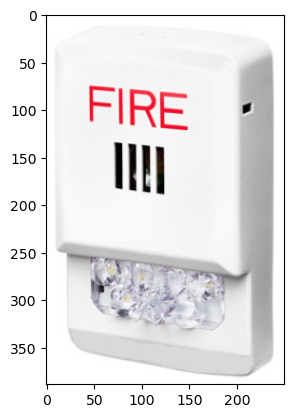

In [32]:
plt.imshow(image)


In [ ]:
# autoregressively complete prompt

output = model_llava.generate(**inputs, max_new_tokens=100)

print(processor_llava.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
What is shown in this image? [/INST] The image appears to be a radar chart, which is a type of multi-dimensional plot that displays values for multiple quantitative variables represented on axes starting from the same point. This particular radar chart is showing the performance of different models or systems across various metrics.

The axes represent different metrics or benchmarks, such as MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-


### QWEN 3VL

In [21]:
model_qwen = Qwen3VLForConditionalGeneration.from_pretrained(
"Qwen/Qwen3-VL-8B-Instruct", dtype="auto", device_map="cuda:0"
)
processor_qwen = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
image_path = documents_path + "pdfs/extracted_images/vacuum_circuitbreaker/vacuum_circuitbreaker_p2_x3_w496_h624.png"
image = Image.open(image_path)

# Helper function for multimodal messages in Qwen format

messages = [
        {
            "role": "user", 
            "content": [
                {"type": "text", "text": "What is shown in this image, be concise?"},
                {"type": "image", "image": image},
                
            ]
        }
    ]

# Process the messages correctly

inputs = processor_qwen.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
            )
inputs = inputs.to(model_qwen.device)

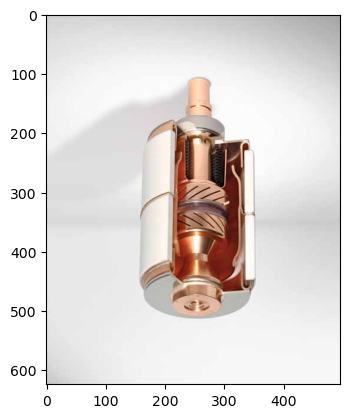

In [23]:
plt.imshow(image)


In [24]:
# Inference: Generation of the output

generated_ids = model_qwen.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
output_text = processor_qwen.batch_decode(generated_ids_trimmed, skip_special_tokens=True,
                                          clean_up_tokenization_spaces=True)
print(output_text)  


['A cutaway view of a mechanical device, likely a precision instrument or component, revealing internal gears and mechanisms.']


### Building The Multimodal Pipeline

In [34]:
retriever_multimodal_image = RetrieverMultiModal_experimental(vector_db_text=vector_db_manager_pdf,
                            vector_db_image=vector_db_manager_pdf_images,
                            embedding_manager_text=embedding_manager_txt,
                            embedding_manager_image=embedding_manager_images)

mm_rag = AdvancedMultimodalRAG(
    retriever_multimodal=retriever_multimodal_image,
    model_llava=None,
    processor_llava=None,
    model_qwen=model_qwen,
    processor_qwen=processor_qwen,
    text_llm=llm_llama31
)

In [35]:
query_mm_rag = "Explain how Siemens SAMMS-MV device connects to the SEAbus, referring to both text and images."


result_qwen = mm_rag.generate_response(
    query= query_mm_rag,
    backend="qwen_vl",
    top_k_text=3,
    top_k_image=3,
    match_threshold_text=-0.5,
    match_threshold_image=-0.7,
    max_images=2,
    preprocess_type="expand",   # or None / "chain_of_thought"
    summarize=False,
    image_query_captioning=True,
    max_new_tokens=1000
)

Generating multimodal response for query: Explain how Siemens SAMMS-MV device connects to the SEAbus, referring to both text and images.
Expanded retrieval query:
 Here's an expanded query to improve retrieval accuracy:

"Explain the connection process of the Siemens SAMMS-MV (Safety and Monitoring Management System for Medium Voltage) device to the SEAbus (Siemens Energy Automation Bus) communication network, including a detailed description of the hardware and software requirements, as well as the necessary configuration steps. Provide a comprehensive overview of the connection process, including any relevant diagrams, illustrations, or images that demon ...

Generated image caption for retrieval:
 "Schematic diagram of Siemens SAMMS-MV device connection to SEAbus, highlighting relevant interfaces and ports." ...

Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.7.
Text context length: 9998
Using 2 image(s) for generation.
Answer from backend qwen_vl: 
Based on the provided text and images, the Siemens SAMMS-MV device connects to the SEAbus™ RS-485 network through its Communications Module, CM-1.

The connection is established via a 5-pin plug located on the CM-1 module. The specific pinout for this connection is detailed in the text as follows:
*   Pin 1: Negative (-)
*   Pin 2: Ground (GND)
*   Pin 3: Positive (+)
*   Pin 4: 12VDC+
*   Pin 5: 12VDC-

The text also notes that the SAMMS-MV device is designed to operate within the ACCESS electr



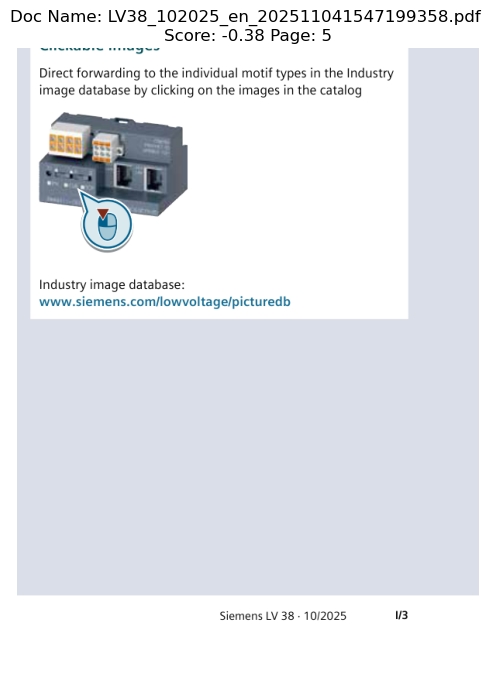

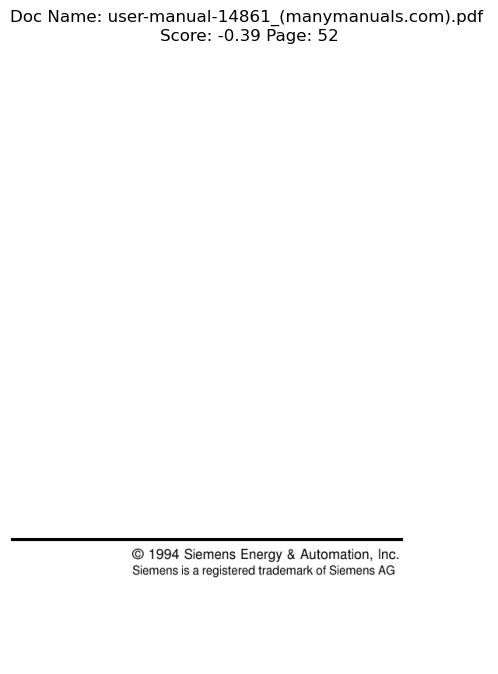

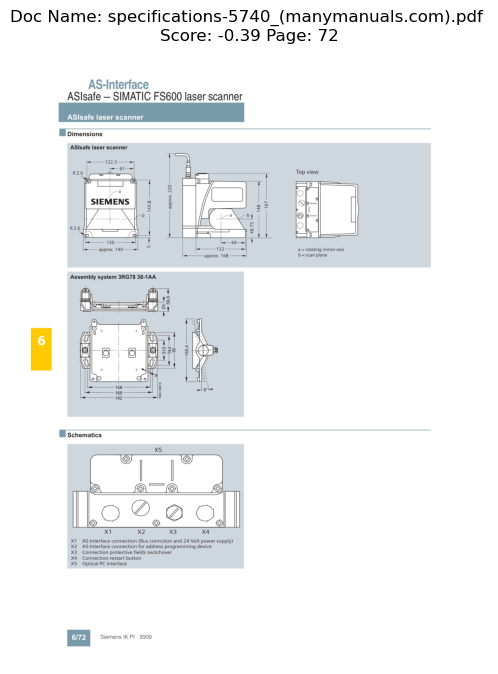

In [44]:
# show the retrieved images in full size
retrieved_image_docs = result_qwen["retrieved_image_docs"]
for i, img_doc in enumerate(retrieved_image_docs):
    img_path = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Doc Name: {img_doc['metadata'].get('doc_id')} \n"
                  f"Score: {img_doc['score']:.2f} Page: {img_doc['metadata'].get('page')}")
        plt.show()

### Example Evaluation


In [45]:
print("Eval dataset path:", eval_dataset_path)

eval_path = Path(eval_dataset_path)
assert eval_path.exists(), f"Dataset not found at {eval_path}"

with open(eval_path, "r", encoding="utf-8") as f:
    eval_data = json.load(f)

print(f"Loaded {len(eval_data)} evaluation examples.")
print("Example item:\n", eval_data[0])

Eval dataset path: ../eval/dataset.json
Loaded 30 evaluation examples.
Example item:
 {'id': 'A6V12681514_p2_q0001', 'pdf_name': 'A6V12681514.pdf', 'pdf_path': 'C:\\Users\\rozku\\Desktop\\Research_Internship\\Project\\siemens_test\\pdfs\\A6V12681514.pdf', 'page': 2, 'question': 'The following is a question about an industrial device. Give only the letter choice in your answer.\n\nQuestion: For the SSE131.09U actuator using a 3-position control signal, what happens when voltage is applied to terminal Y1?\nA. The actuator stem extends; the normally open valve closes\nB. The actuator stem retracts; the normally open valve opens\nC. The actuator maintains its current position\nD. The actuator performs a self-calibration cycle\nAnswer:', 'answer': 'B', 'question_type': 'multiple_choice', 'structured_metadata': {'type': 'multiple_choice', 'choices': ['A', 'B', 'C', 'D'], 'correct_index': 0}, 'timestamp': '2025-11-18T03:10:13Z'}


In [46]:
# load pipeline for qwen, no preprocessing llm this time

mm_rag_qwen = AdvancedMultimodalRAG(
    retriever_multimodal=retriever_multimodal_image,
    model_llava=None,
    processor_llava=None,
    model_qwen=model_qwen,
    processor_qwen=processor_qwen,
    text_llm=None,   # no Groq / extra text LLM for preprocessing during evaluation
)

print("AdvancedMultimodalRAG for Qwen-VL is ready:", mm_rag_qwen is not None)

AdvancedMultimodalRAG for Qwen-VL is ready: True


In [47]:
# helper functions for evaluation

CHOICE_LETTERS = ["A", "B", "C", "D"]

def answer_question_with_qwen(example, mm_rag, verbose=False):
    """
    Run the AdvancedMultimodalRAG pipeline (Qwen-VL backend) for a single example.
    Returns:
        raw_answer_text (str)
        full_result_dict (dict from AdvancedMultimodalRAG.generate_response)
    """
    question_text = example["question"]

    if verbose:
        print("Question ID:", example.get("id"))
        print(question_text)

    result = mm_rag.generate_response(
        query=question_text,
        backend="qwen_vl",
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.6,
        max_images=3,
        max_new_tokens=64,
        preprocess_type=None,   # no query expansion / CoT for retrieval during eval
        summarize=False,
    )

    raw_answer = result["answer"]
    return raw_answer, result


# Regex-based parser to extract a letter choice A–D from Qwen's answer
def extract_choice_letter(answer_text):
    """
    Try to extract a multiple-choice letter (A/B/C/D) from the model's output.
    Returns:
        "A"/"B"/"C"/"D" or None if nothing is found.
    """
    if not answer_text:
        return None

    txt = answer_text.strip()

    # 1) Look for patterns like "Answer: B" or "Answer - C"
    m = re.search(r"Answer\s*[:\-]\s*([ABCD])", txt, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    # 2) Look for things like "B)" or "B." at the start of a line
    m = re.search(r"^\s*([ABCD])[\)\.]\s", txt, flags=re.IGNORECASE | re.MULTILINE)
    if m:
        return m.group(1).upper()

    # 3) Fallback: first standalone A-D token anywhere
    m = re.search(r"\b([ABCD])\b", txt, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    # Nothing found
    return None


In [48]:
results = []

for ex in tqdm(eval_data, desc="Evaluating Qwen-VL RAG"):
    gt = ex["answer"].strip().upper()

    raw_answer, full = answer_question_with_qwen(ex, mm_rag_qwen)
    pred = extract_choice_letter(raw_answer)

    is_correct = int(pred == gt) if pred else 0

    results.append({
        "id": ex["id"],
        "pdf_name": ex["pdf_name"],
        "pdf_path": ex["pdf_path"],
        "page": ex["page"],
        "question": ex["question"],
        "gt_answer": gt,
        "pred_answer": pred,
        "is_correct": is_correct,
        "raw_output": raw_answer,

        # retrieval info
        "n_text_docs": len(full.get("retrieved_text_docs", [])),
        "n_image_docs": len(full.get("retrieved_image_docs", [])),
        "n_images_used": len(full.get("image_paths_used", [])),
    })

df = pd.DataFrame(results)
df.head()


Evaluating Qwen-VL RAG:   0%|          | 0/30 [00:00<?, ?it/s]

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: For the SSE131.09U actuator using a 3-position control signal, what happens when voltage is applied to terminal Y1?
A. The actuator stem extends; the normally open valve closes
B. The actuator stem retracts; the normally open valve opens
C. The actuator maintains its current position
D. The actuator performs a self-calibration cycle
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4855
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:   3%|▎         | 1/30 [00:01<00:53,  1.85s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: During self-calibration of the SSE161.05U or SSF161.05U actuator, which condition causes calibration failure?
A. Valve stroke greater than 0.25 inch (6.5 mm)
B. Valve stroke less than 0.05 inch (1.2 mm)
C. Operating voltage higher than 24 V
D. Y1 and Y2 signals applied simultaneously
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4441
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:   7%|▋         | 2/30 [00:03<00:50,  1.79s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What is the operating voltage of the SSE161.05U actuator?
A. AC 120 V
B. AC/DC 24 V
C. DC 48 V
D. AC 12 V
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 3848
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  10%|█         | 3/30 [00:05<00:47,  1.75s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: For the SSE131.09U actuator, what control type is used?
A. PWM
B. 3-position (floating)
C. Binary ON/OFF
D. Modbus RTU
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4294
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  13%|█▎        | 4/30 [00:06<00:44,  1.73s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: At DC 0 V on an SSE161.05U actuator, what is the stem position for a normally closed valve?
A. Fully open
B. Oscillating
C. Mid-stroke
D. Fully closed
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4871
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  17%|█▋        | 5/30 [00:08<00:43,  1.75s/it]

Answer from backend qwen_vl: 
D

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What does a constant red LED (LED2) indicate on the actuator?
A. Error
B. Calibration
C. Manual override active
D. Stem fully extended
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4269
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  20%|██        | 6/30 [00:10<00:41,  1.73s/it]

Answer from backend qwen_vl: 
A

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: How many SSE161.05U actuators can be operated in parallel if the controller output is sufficient?
A. 3
B. 5
C. 10
D. 20
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4878
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  23%|██▎       | 7/30 [00:12<00:40,  1.76s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: During self-calibration, what sequence does the actuator follow?
A. Mid-stroke → fully extended → retracted
B. Fully extended → retracted → mid-stroke
C. Fully retracted → fully extended → setpoint
D. Randomized movement to detect stroke
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4211
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  27%|██▋       | 8/30 [00:14<00:38,  1.75s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What happens after three failed calibration attempts on an SSE161.05U?
A. The actuator shuts down completely
B. The stem remains extended and valves stay open
C. The controller restarts the calibration
D. A manual override is automatically triggered
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4855
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  30%|███       | 9/30 [00:15<00:36,  1.75s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What is required for correct calibration?
A. Valve stroke > 0.05 inch (1.2 mm)
B. Valve stroke < 0.05 inch (1.2 mm)
C. High ambient humidity
D. Manual override engaged
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4977
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  33%|███▎      | 10/30 [00:17<00:35,  1.76s/it]

Answer from backend qwen_vl: 
A

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: For SSE161.05U and SSF161.05U, what is the input impedance of the DC 0–10 V control signal?
A. 1 kΩ
B. 10 kΩ
C. 100 kΩ
D. 1 MΩ
Answer: C
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4802
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  37%|███▋      | 11/30 [00:19<00:33,  1.78s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: When the actuator is de-energized, what does it do?
A. Automatically retracts fully
B. Automatically extends fully
C. Maintains its current position
D. Returns to factory calibration
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4581
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  40%|████      | 12/30 [00:21<00:31,  1.76s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In the front panel of the SAMMS-MV device, which LED is located at the top-left of the diagnostic LED column as shown in the figure?
A. CPU Fault
B. Ground Fault
C. Current Unbalance
D. External Trip
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5110
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  43%|████▎     | 13/30 [00:22<00:30,  1.78s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In Figure 3.4, which pushbutton (PB1–PB6) is labeled as the STOP/OFF button?
A. PB6
B. PB3
C. PB1
D. PB4
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4775
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  47%|████▋     | 14/30 [00:24<00:28,  1.78s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: According to the LED status table, when the Phase Unbalance LED is flashing, what does it represent?
A. Current unbalance above 40%
B. Motor winding overheated
C. Current unbalance between 20% and 40%
D. Loss of load
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5327
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  50%|█████     | 15/30 [00:26<00:26,  1.79s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In the full-voltage non-reversing wiring diagram, which terminal numbers are used for the ACT Inputs from the current sensors?
A. Terminals 1–3
B. Terminals 5–6
C. Terminals 14–16
D. Terminals 9–12
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4467
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  53%|█████▎    | 16/30 [00:28<00:25,  1.79s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In the rear-view communications diagram, which pin on the 5-pin connector is labeled “+” for RS-485?
A. Pin 1
B. Pin 3
C. Pin 4
D. Pin 5
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5226
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  57%|█████▋    | 17/30 [00:30<00:23,  1.79s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: According to the dimensional drawing, what is the height of the SAMMS-MV device?
A. 2.125 inches
B. 3.25 inches
C. 6.00 inches
D. 6.25 inches
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 3658
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  60%|██████    | 18/30 [00:31<00:21,  1.76s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What overload trip class does the SAMMS-MV default to?
A. Class 23
B. Class 2
C. Class 10
D. Class 5
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5098
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  63%|██████▎   | 19/30 [00:33<00:19,  1.76s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: What control power input is required to operate the SAMMS-MV device?
A. 24 VDC
B. 115 VAC
C. 12 VAC
D. 5 VDC
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5281
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  67%|██████▋   | 20/30 [00:35<00:17,  1.75s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: For overload relay size H3B, what is the default ground fault pickup current?
A. 7A
B. 10A
C. 20A
D. 40A
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5233
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  70%|███████   | 21/30 [00:37<00:15,  1.77s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In Figure 3.2, what does the circular ladder symbol represent?
A. A timer contact
B. An output device such as a coil driver or pilot LED
C. A remote AC input
D. A pushbutton
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4931
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  73%|███████▎  | 22/30 [00:38<00:14,  1.77s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In the actuator diagram (4540Z01), which numbered component represents the manual adjuster?
A. 3
B. 1
C. 4
D. 5
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4499
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  77%|███████▋  | 23/30 [00:40<00:12,  1.77s/it]

Answer from backend qwen_vl: 
B

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: According to the PCB diagram (4573Z02), how do you set the actuator to a linear flow characteristic?
A. S1 connected to B and C
B. S1 connected to A and C
C. S1 connected to A and B
D. S1 disconnected
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4631
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  80%|████████  | 24/30 [00:42<00:10,  1.77s/it]

Answer from backend qwen_vl: 
A

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: In the wiring diagram for 3-position control (4540A03), which terminals receive the 3-position control voltages?
A. Terminals Y1 and Y2
B. Terminals R and U
C. Terminals 11 and 12
D. Terminals SP and SN
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 3950
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  83%|████████▎ | 25/30 [00:44<00:08,  1.76s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: According to the dimension drawing, what is the overall height (without valve) of the SQD actuator?
A. 32 mm
B. 80 mm
C. 111 mm
D. 128 mm
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 3899
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  87%|████████▋ | 26/30 [00:45<00:07,  1.75s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: Which actuator operates on AC 230 V?
A. SQD65
B. SQD85.03
C. SQD35.00
D. All types
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4741
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  90%|█████████ | 27/30 [00:47<00:05,  1.76s/it]

Answer from backend qwen_vl: 
C

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: For SQD65, which signal closes the valve (A→AB port)?
A. DC 0 V or 0 Ω
B. 1000 Ω
C. DC 10 V
D. Removal of supply voltage
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4284
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  93%|█████████▎| 28/30 [00:49<00:03,  1.75s/it]

Answer from backend qwen_vl: 
A

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: On the terminal strip drawing for SQD65, what does terminal U represent?
A. 3-position input
B. Position feedback output
C. Neutral conductor
D. Auxiliary switch input
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 4666
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG:  97%|█████████▋| 29/30 [00:51<00:01,  1.76s/it]

Answer from backend qwen_vl: 
D

Generating multimodal response for query: The following is a question about an industrial device. Give only the letter choice in your answer.

Question: How many SQD65 actuators can be operated in parallel on the same control signal?
A. 1
B. 3
C. 5
D. 10
Answer:
Retrieving 3 text document chunks and 3 image document chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.
Text context length: 5251
Using 3 image(s) for generation.


Evaluating Qwen-VL RAG: 100%|██████████| 30/30 [00:52<00:00,  1.76s/it]

Answer from backend qwen_vl: 
D



,id,pdf_name,pdf_path,page,question,gt_answer,pred_answer,is_correct,raw_output,n_text_docs,n_image_docs,n_images_used
0,A6V12681514_p2_q0001,A6V12681514.pdf,C:\Users\rozku\Desktop\Research_Internship\Pro...,2,The following is a question about an industria...,B,B,1,B,3,3,3
1,A6V12681514_p2_q0002,A6V12681514.pdf,C:\Users\rozku\Desktop\Research_Internship\Pro...,2,The following is a question about an industria...,B,B,1,B,3,3,3
2,A6V12681514_p2_q0003,A6V12681514.pdf,C:\Users\rozku\Desktop\Research_Internship\Pro...,2,The following is a question about an industria...,B,B,1,B,3,3,3
3,A6V12681514_p2_q0004,A6V12681514.pdf,C:\Users\rozku\Desktop\Research_Internship\Pro...,2,The following is a question about an industria...,B,C,0,C,3,3,3
4,A6V12681514_p2_q0005,A6V12681514.pdf,C:\Users\rozku\Desktop\Research_Internship\Pro...,2,The following is a question about an industria...,D,D,1,D,3,3,3


In [49]:
# metrics
print("Accuracy:", df["is_correct"].mean())

mask = df["pred_answer"].notna()
y_true = df.loc[mask, "gt_answer"]
y_pred = df.loc[mask, "pred_answer"]

print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=CHOICE_LETTERS))

print("\nConfusion matrix:")
cm = confusion_matrix(y_true, y_pred, labels=CHOICE_LETTERS)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in CHOICE_LETTERS],
                          columns=[f"pred_{c}" for c in CHOICE_LETTERS])
cm_df


Accuracy: 0.8

Classification report:
              precision    recall  f1-score   support

           A       1.00      0.67      0.80         6
           B       0.89      0.80      0.84        10
           C       0.71      0.91      0.80        11
           D       0.67      0.67      0.67         3

    accuracy                           0.80        30
   macro avg       0.82      0.76      0.78        30
weighted avg       0.82      0.80      0.80        30


Confusion matrix:


,pred_A,pred_B,pred_C,pred_D
true_A,4,0,2,0
true_B,0,8,1,1
true_C,0,1,10,0
true_D,0,0,1,2


In [50]:
output_csv = "qwen_vl_multimodal_rag_results.csv"
df.to_csv(output_csv, index=False, encoding="utf-8")

print("Saved:", output_csv)


Saved: qwen_vl_multimodal_rag_results.csv


In [ ]:
del embedding_manager_txt
del embedding_manager_images
del model_llava
del processor_llava
del CLIPModel
del model_qwen
del processor_qwen
del embeddings_pdf
del embeddings_pdf_images
del embeddings_pdf_pages
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()